# MLP for Image Recognition

## Import data

In [6]:
import tensorflow as tf
import numpy as np 
import pandas as pd
from pandas_ml import ConfusionMatrix
import seaborn as sns
import cv2
import glob
import os
from random import shuffle

In [7]:
dataset_path = './dataset/'
image_height = 128
image_width = 128
image_depth = 3
epoch = 10
batch_size = 30

In [8]:
def folder_image_class(base_dataset_path=dataset_path):
	'''
	Returns a 2-D list of images path and corresponding labels each in a separate list, total num of files and a list containing 
	classes names.
	The images should be segregated into different folders according to its class and the folders should be
	named after its class.
	
	Parameter
	---------
	base_dataset_path : the path of the dataset folder   | string

	'''

	#Recursively iterates through all the images in the folder .
	#As glob function also returns the folder path (which is unnecessary in our case), we omit it by
	#filtering for it using os.path.isdir function.
	image_path_list = [x for x in glob.glob(base_dataset_path + '/**', recursive=True) if not os.path.isdir(x)]

	#Since the images path also contains the name of the folder (which is the name of the class), we slice the string starting
	#from the base dataset path length and split it by '/'. The name of the folder will be in the first index.
	class_list = [x[len(base_dataset_path):].split('/')[0] for x in image_path_list]

	#Remove duplicates and sort the class names alphabetically in ascending order.
	classes = list(set(class_list))
	classes.sort()

	#Total number of files.
	total_files = len(image_path_list)

	#Create the 2-D list of images and corresponding labels.
	img_label_list = [[x for x in image_path_list], [x for x in class_list]]

	#Shuffle the lists.
	#We have to zip both the list so that the order is maintained.
	combined = list(zip(img_label_list[0], img_label_list[1]))
	shuffle(combined)

	#Retrieve the shuffled list.
	img_label_list[0][:],img_label_list[1][:] = zip(*combined)


	return (img_label_list, total_files, classes)

In [9]:
def one_hot_encoder(label, classes_list):
	'''
	Returns a one-hot list equivalent of the label.

	Parameter
	---------

	label        : the name of the class   | string
	classes_list : list of all the classes | list
	
	'''

	total_classes = len(classes_list)

	#Create a list of zeros with the length of the total num of classes.
	one_hot_list = [0.0] * total_classes

	#Marks 1.0 at the index of the class
	one_hot_list[classes_list.index(label)] = 1.0

	return one_hot_list

In [10]:
def get_batch_dataset(img_label_list,classes_list, start, end):
	'''
	Returns a batch of numpy array consisting of images and one hot labels.
	Size of batch can be controlled using the start and end parameter.
	'''

	images = []
	labels = []

	if end is None:
		end = len(img_label_list[0]) #so there'll be one iteration when start is in the last index.

	for i in range(start, end): 

		im = None

		if image_depth == 3: #RGB mode

			im = cv2.imread(img_label_list[0][i])

		elif image_depth == 1: #grayscale mode

			im = cv2.imread(img_label_list[0][i] ,0)


		im = cv2.resize(im ,(image_height, image_width))
		images.append(im)

		label = np.asarray(one_hot_encoder(img_label_list[1][i], classes_list)) #convert the label into one hot np array
		labels.append(label)

	return (np.asarray(images), np.asarray(labels))

In [11]:
#get the list of the dataset and its corresponding labels
img_label_list, total_files, classes = folder_image_class(dataset_path)

### Details about the dataset

In [12]:
print("Total number of training examples : ", total_files)
print("Classes list : ", classes)
print("Accordion examples : ", img_label_list[1].count("accordion"))
print("Airplanes examples : ", img_label_list[1].count("airplanes"))
print("Buddha examples    : ", img_label_list[1].count("buddha"))
print("Watch examples     : ", img_label_list[1].count("watch"))

Total number of training examples :  442
Classes list :  ['accordion', 'airplanes', 'buddha', 'watch']
Accordion examples :  44
Airplanes examples :  77
Buddha examples    :  82
Watch examples     :  239


### MLP

In [13]:
sess = tf.InteractiveSession()

x = tf.placeholder(tf.float32, [None, image_height,image_width,image_depth])
x_reshape = tf.reshape(x, (-1, image_height*image_width*image_depth))
y = tf.placeholder(tf.float32, [None, len(classes)])

W = tf.Variable(tf.zeros([image_height*image_width*image_depth, len(classes)]))
B = tf.Variable(tf.zeros([len(classes)]))

y_ = tf.matmul(x_reshape, W) + B


cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=y_))
train_step = tf.train.GradientDescentOptimizer(0.1).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [14]:
sess.run(tf.global_variables_initializer())

In [15]:
for epoch_idx in range(epoch):
    
    loss_total = 0.0
    total_accuracy = 0.0
    loop_counter = 0
    
    for start_idx in range(0, total_files, batch_size):
        
        end_idx = start_idx + batch_size
        
        if end_idx > total_files : end_idx = total_files
        
        images, targets = get_batch_dataset(img_label_list,classes, start=start_idx, end=end_idx) #get the batch dataset
        
        _, loss_, accuracy_ = sess.run([train_step, cross_entropy, accuracy], feed_dict={x:images,
                                                                                         y:targets})
        
        loss_total += loss_
        total_accuracy += accuracy_
        loop_counter += 1
    
    total_accuracy = total_accuracy/loop_counter
    
    print("Epoch %d, Loss %g, Accuracy %g "%(epoch_idx, loss_total, total_accuracy))
    
    if epoch_idx ==  epoch - 1: #last epoch 
        
        pred_list = []
        actual_list = []
        
        for start_idx in range(0, total_files, batch_size):
        
            end_idx = start_idx + batch_size

            if end_idx > total_files : end_idx = total_files

            images, targets = get_batch_dataset(img_label_list,classes, start=start_idx, end=end_idx) #get the batch dataset

            pred = sess.run(y_, feed_dict={x:images, y:targets}) #get the logits
            
            #convert the index numbers to class names
            pred_ = [classes[int(x)] for x in np.argmax(pred, axis=1)] 
            targets_ = [classes[int(x)] for x in np.argmax(targets, axis=1)]
            
            pred_list.append(pred_)
            actual_list.append(targets_)
    
        
        pred_list = sum(pred_list, []) #convert 2D list to 1D
        actual_list = sum(actual_list, [])

Epoch 0, Loss 2.22905e+08, Accuracy 0.477778 
Epoch 1, Loss 2.25805e+08, Accuracy 0.493535 
Epoch 2, Loss 9.29443e+07, Accuracy 0.630101 
Epoch 3, Loss 7.89004e+07, Accuracy 0.68404 
Epoch 4, Loss 5.75757e+07, Accuracy 0.727071 
Epoch 5, Loss 4.4755e+07, Accuracy 0.754545 
Epoch 6, Loss 4.32053e+07, Accuracy 0.767879 
Epoch 7, Loss 1.83744e+07, Accuracy 0.848081 
Epoch 8, Loss 6.10908e+07, Accuracy 0.777374 
Epoch 9, Loss 4.22968e+07, Accuracy 0.748687 


### Confusion Matrix 

In [16]:
data = {'predicted': pred_list,
        'actual':   actual_list,
        }
df = pd.DataFrame(data, columns=['actual','predicted'])
confusion_matrix = pd.crosstab(df['actual'], df['predicted'], rownames=['Actual'], colnames=['Predicted'])

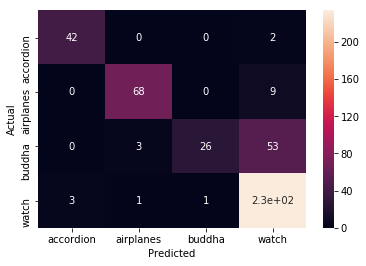

In [17]:
sns.heatmap(confusion_matrix, annot=True)

It seems that the model has overfitted to _Watch_ class as it **Falsely** predicted many of _Buddha_ classes and others as _Watch_. This is fair given that the examples in the _Watch_ class were a lot more compared to the examples in other classes.

In [18]:
cm = ConfusionMatrix(df['actual'], df['predicted'])

In [20]:
stats = cm.stats()
cm.print_stats()

Confusion Matrix:

Predicted  accordion  airplanes  buddha  watch  __all__
Actual                                                 
accordion         42          0       0      2       44
airplanes          0         68       0      9       77
buddha             0          3      26     53       82
watch              3          1       1    234      239
__all__           45         72      27    298      442


Overall Statistics:

Accuracy: 0.8371040723981901
95% CI: (0.7993126513082066, 0.8703070845858597)
No Information Rate: ToDo
P-Value [Acc > NIR]: 6.7576151464361264e-15
Kappa: 0.721827908115101
Mcnemar's Test P-Value: ToDo


Class Statistics:

Classes                                 accordion  airplanes      buddha  \
Population                                    442        442         442   
P: Condition positive                          44         77          82   
N: Condition negative                         398        365         360   
Test outcome positive                  

In [21]:
stats['class']

Classes,accordion,airplanes,buddha,watch
Population,442,442,442,442
P: Condition positive,44,77,82,239
N: Condition negative,398,365,360,203
Test outcome positive,45,72,27,298
Test outcome negative,397,370,415,144
TP: True Positive,42,68,26,234
TN: True Negative,395,361,359,139
FP: False Positive,3,4,1,64
FN: False Negative,2,9,56,5
"TPR: (Sensitivity, hit rate, recall)",0.954545,0.883117,0.317073,0.979079


In [23]:
stats['class'].loc['F1 score']

Classes
accordion     0.94382
airplanes    0.912752
buddha       0.477064
watch        0.871508
Name: F1 score, dtype: object

Overall, the model is very good at detecting _Accordion_ and very bad at detecting _Buddha_.